# Robotics, Vision & Control 3e: for Python
## Chapter 3: Time and Motion

Copyright (c) 2021- Peter Corke

In [176]:
try:
    from google.colab import output

    print("Running on CoLab")
    output.enable_custom_widget_manager()
    !pip install ipympl
    !pip install spatialmath-python
    !pip install roboticstoolbox-python>=1.0.2
    !pip install --no-deps rvc3python
    COLAB = True

except ModuleNotFoundError:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

from IPython.display import HTML
import urllib.request

# add RTB examples folder to the path
import sys, os.path
import roboticstoolbox as rtb
import RVC3

# sys.path.append(os.path.join(rtb.__path__[0], 'examples'))
sys.path.append(os.path.join(RVC3.__path__[0], "examples"))

# standard imports
import numpy as np
import matplotlib.pyplot as plt
import math
from math import pi

np.set_printoptions(
    linewidth=120,
    formatter={"float": lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"},
)
np.random.seed(0)
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import quintic, trapezoidal, mtraj, mstraj, xplot, ctraj

# Configure matplotlib for interactive plots
try:
    %matplotlib widget
    print("Using matplotlib widget backend for interactive plots")
except:
    %matplotlib inline
    print("Using matplotlib inline backend")

import matplotlib.pyplot as plt

Using matplotlib inline backend


There are some minor code changes compared to the book. These are to support 
the Matplotlib widget (ipympl) backend.  This allows 3D plots to be rotated
so the changes are worthwhile.

## Animation Notes

This notebook has been updated to work better with different matplotlib backends:

- **Interactive animations**: When `%matplotlib widget` is available, animations should work interactively
- **Fallback mode**: If animations fail, static plots showing key frames will be displayed instead
- **HTML exports**: The original HTML animation exports have been replaced with more robust alternatives

If you see "Animation error" messages, this is normal fallback behavior when the interactive backend is not available.

# 3.1 Time-Varying Pose


## 3.1.3 Transforming Spatial Velocities


In [177]:
aTb = SE3.Tx(-2) * SE3.Rz(-pi / 2) * SE3.Rx(pi / 2);

In [178]:
bV = [1, 2, 3, 4, 5, 6];

In [179]:
aJb = aTb.jacob()
aJb.shape
aV = aJb @ bV

array([      -3,       -1,        2,       -6,       -4,        5])

In [180]:
aV = aTb.Ad() @ [1, 2, 3, 0, 0, 0]

array([      -3,       -1,        2,        0,        0,        0])

In [181]:
aV = aTb.Ad() @ [0, 0, 0, 1, 0, 0]

array([       0,        0,        2,        0,       -1,        0])

In [182]:
aV = aTb.Ad() @ [1, 2, 3, 1, 0, 0]

array([      -3,       -1,        4,        0,       -1,        0])

## 3.1.4 Incremental Rotation


In [183]:
rotx(0.001)

array([[       1,        0,        0],
       [       0,        1,   -0.001],
       [       0,    0.001,        1]])

In [184]:
import time

Rexact = np.eye(3)
Rapprox = np.eye(3)  # null rotation
w = np.array([1, 0, 0])  # rotation of 1rad/s about x-axis
dt = 0.01  # time step
t0 = time.process_time()
for i in range(100):  # exact integration over 100 time steps
    Rexact = Rexact @ trexp(skew(w * dt))  # update by composition
print(time.process_time() - t0)

t0 = time.process_time()
for i in range(100):  # approximate integration over 100 time steps
    Rapprox = Rapprox + Rapprox @ skew(w * dt)  # update by addition
print(time.process_time() - t0)

0.0031789789999976392
0.0007804239999984475


In [185]:
np.linalg.det(Rapprox) - 1

0.010049662092876055

In [186]:
np.linalg.det(Rexact) - 1

-2.886579864025407e-15

In [187]:
tr2angvec(trnorm(Rexact))

(1.0, array([       1,        0,        0]))

In [188]:
tr2angvec(trnorm(Rapprox))

(0.999966668666524, array([       1,        0,        0]))

# 3.2 Accelerating Bodies and Reference Frames


## 3.2.1 Dynamics of Moving Bodies


In [189]:
J = np.array([[2, -1, 0], [-1, 4, 0], [0, 0, 3]])
orientation = UnitQuaternion()  # identity quaternion
w = 0.2 * np.array([1, 2, 2]);

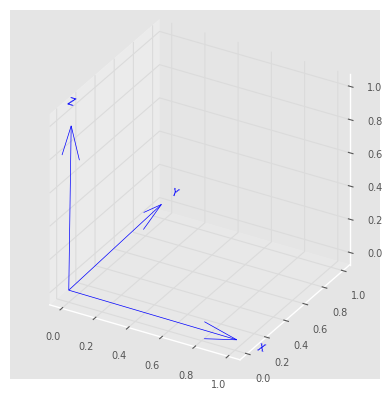

In [190]:
dt = 0.05  # time step


def update():
    global orientation, w
    for t in np.arange(0, 10, dt):
        wd = -np.linalg.inv(J) @ (np.cross(w, J @ w))  # (3.12)
        w += wd * dt
        orientation *= UnitQuaternion.EulerVec(w * dt)
        yield orientation.R


# Use matplotlib widget for interactive animation
plotvol3(new=True)
try:
    # Use tranimate without extra dim parameter since it may be passed internally
    tranimate(update())
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing static final orientation instead:")
    # Show final orientation as static plot
    final_orientation = orientation
    for _ in update():
        final_orientation = orientation
    # Use plotvol3 without conflicting parameters
    plotvol3(final_orientation.R, new=True)

## 3.2.2 Transforming Forces and Torques


In [191]:
bW = [1, 2, 3, 0, 0, 0];

In [192]:
aW = aTb.inv().Ad().T @ bW

array([      -3,       -1,        2,        0,        4,        2])

# 3.3 Creating Time-Varying Pose


## 3.3.1 Smooth One-Dimensional Trajectories


In [193]:
traj = quintic(0, 1, np.linspace(0, 1, 50));

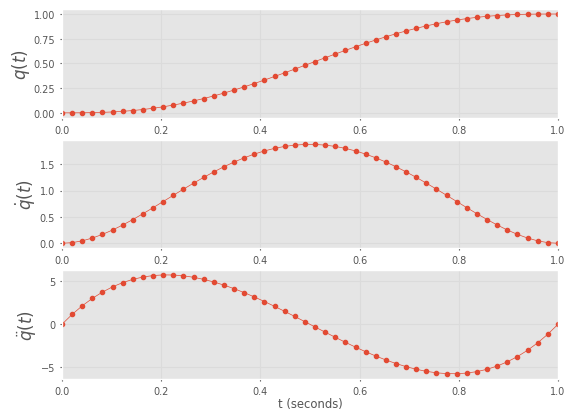

In [194]:
traj.plot();

In [195]:
quintic(0, 1, np.linspace(0, 1, 50), qd0=10, qdf=0);

In [196]:
qd = traj.qd
qd.mean() / qd.max()

0.523102222222222

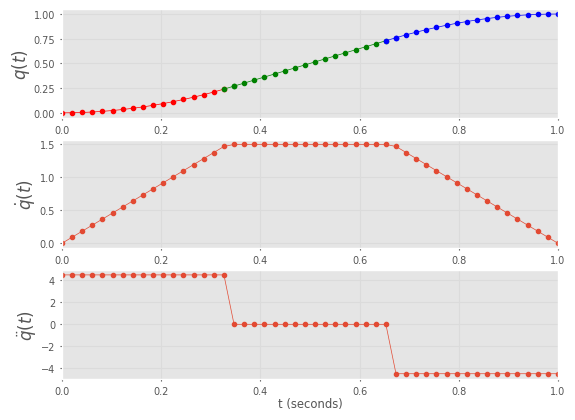

In [197]:
traj = trapezoidal(0, 1, np.linspace(0, 1, 50))
traj.plot();

In [198]:
traj.qd.max()

1.5

In [199]:
traj1_2 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=1.2)
traj2_0 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=2);

## 3.3.2 Multi-Axis Trajectories


In [200]:
traj = mtraj(trapezoidal, [0, 2], [1, -1], 50);

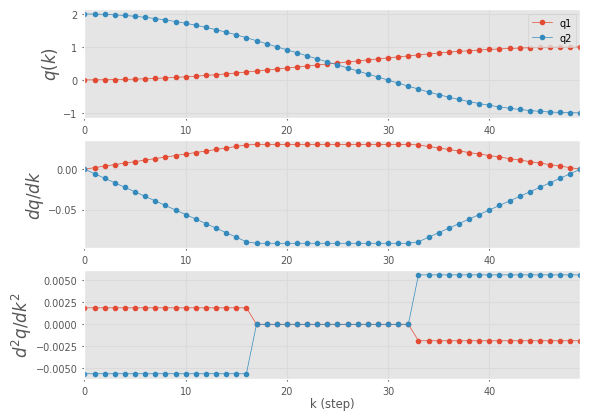

In [201]:
traj.plot();

In [202]:
T = SE3.Rand()
q = np.hstack([T.t, T.rpy()])

array([ 0.09763,   0.4304,   0.2055,    2.777,   -1.125,    1.781])

## 3.3.3 Multi-Segment Trajectories


In [203]:
via = SO2(30, unit="deg") * np.array([[-1, 1, 1, -1, -1], [1, 1, -1, -1, 1]])
traj0 = mstraj(via.T, dt=0.2, tacc=0, qdmax=[2, 1]);

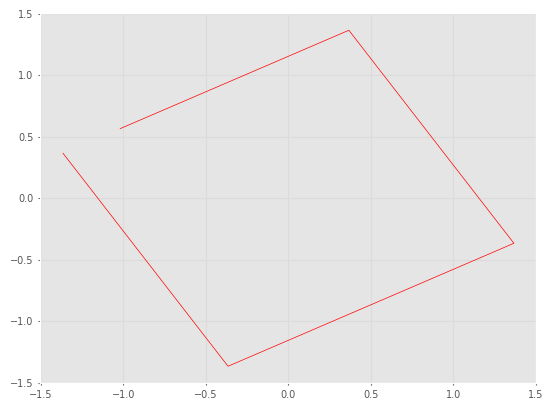

In [204]:
# xplot(traj0.q[:, 0], traj0.q[:, 1], color="red");
plt.plot(traj0.q[:, 0], traj0.q[:, 1], color="red");

In [205]:
traj2 = mstraj(via.T, dt=0.2, tacc=2, qdmax=[2, 1]);

In [206]:
len(traj0), len(traj2)

(28, 80)

## 3.3.4 Interpolation of Orientation in 3D


In [207]:
R0 = SO3.Rz(-1) * SO3.Ry(-1)
R1 = SO3.Rz(1) * SO3.Ry(1);

In [208]:
rpy0 = R0.rpy()
rpy1 = R1.rpy();

In [209]:
traj = mtraj(quintic, rpy0, rpy1, 50);

In [210]:
pose = SO3.RPY(traj.q)
len(pose)

50

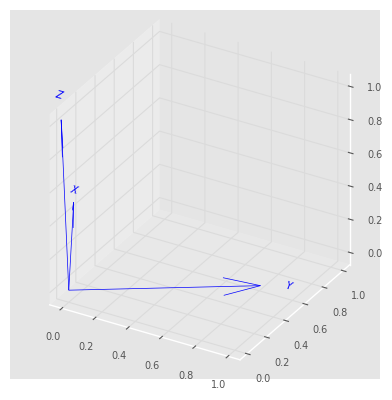

In [211]:
plotvol3(new=True)
try:
    pose.animate()
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing static poses instead:")
    # Show a few key poses
    for i in [0, 12, 25, 37, 49]:
        if i < len(pose):
            plotvol3(pose[i].R, alpha=0.6)

In [212]:
q0 = UnitQuaternion(R0)
q1 = UnitQuaternion(R1);

In [213]:
qtraj = q0.interp(q1, 50)
len(qtraj)

50

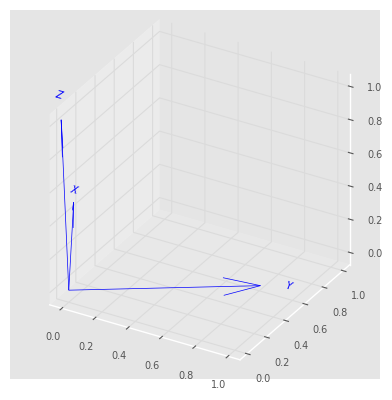

In [214]:
plotvol3(new=True)
try:
    qtraj.animate()
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing static trajectory instead:")
    # Show key frames of the trajectory
    for i in [0, 12, 25, 37, 49]:
        if i < len(qtraj):
            plotvol3(qtraj[i].R, alpha=0.6)

### 3.3.4.1 Direction of Rotation


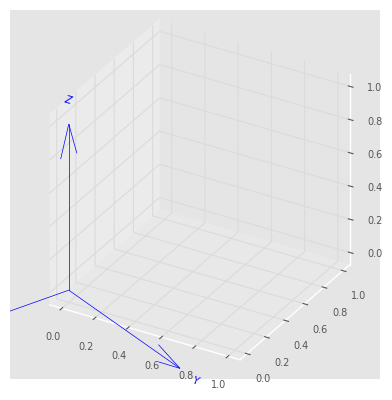

In [215]:
q0 = UnitQuaternion.Rz(-2)
q1 = UnitQuaternion.Rz(2)
q = q0.interp(q1, 50)

plotvol3(new=True)
try:
    q.animate()
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing trajectory endpoint orientations:")
    plotvol3(q[0].R, alpha=0.8)
    plotvol3(q[-1].R, alpha=0.8)

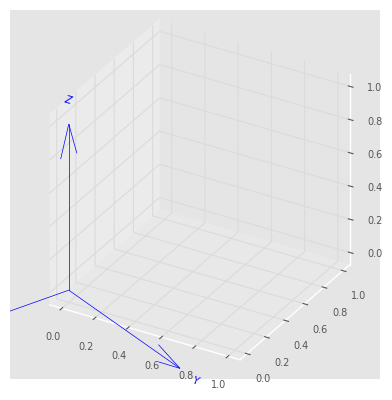

In [216]:
q = q0.interp(q1, 50, shortest=True)

plotvol3(new=True)
try:
    q.animate()
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing shortest path trajectory endpoints:")
    plotvol3(q[0].R, alpha=0.8)
    plotvol3(q[-1].R, alpha=0.8)
    print(f"Trajectory has {len(q)} frames")

## 3.3.5 Cartesian Motion in 3D


In [217]:
T0 = SE3.Trans([0.4, 0.2, 0]) * SE3.RPY(0, 0, 3)
T1 = SE3.Trans([-0.4, -0.2, 0.3]) * SE3.RPY(-pi / 4, pi / 4, -pi / 2);

In [218]:
T0.interp(T1, 0.5)

  -0.7205    0.6578    0.2196    0         
  -0.6578   -0.5479   -0.5168    0         
  -0.2196   -0.5168    0.8274    0.15      
   0         0         0         1         


In [219]:
Ts = T0.interp(T1, 51);

In [220]:
len(Ts)

51

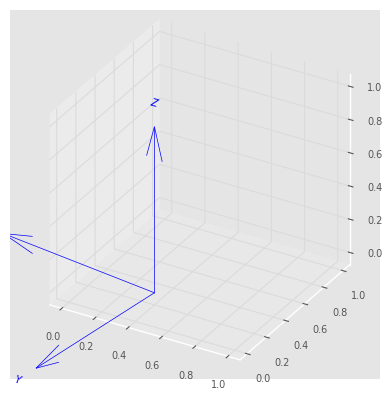

In [221]:
# Ts.animate()
plotvol3(new=True)
try:
    Ts.animate()
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing SE3 trajectory endpoints:")
    # Plot start and end poses
    plotvol3(Ts[0], alpha=0.8)
    plotvol3(Ts[-1], alpha=0.8)
    # Plot trajectory path
    P = Ts.t
    plt.plot(P[:, 0], P[:, 1], P[:, 2], "b-", linewidth=2)
    plt.legend(["Start", "End", "Trajectory"])

In [222]:
Ts[25]

  -0.7205    0.6578    0.2196    0         
  -0.6578   -0.5479   -0.5168    0         
  -0.2196   -0.5168    0.8274    0.15      
   0         0         0         1         


In [223]:
P = Ts.t
P.shape

(51, 3)

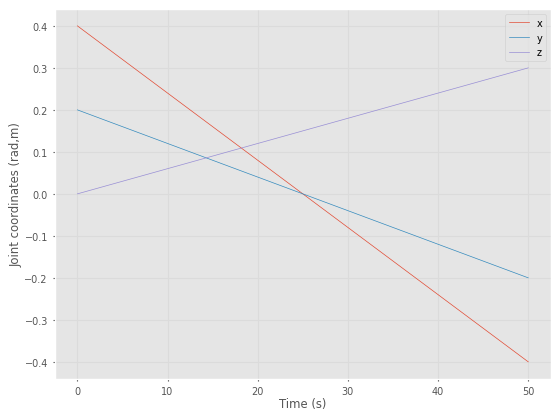

In [224]:
xplot(P, labels="x y z");

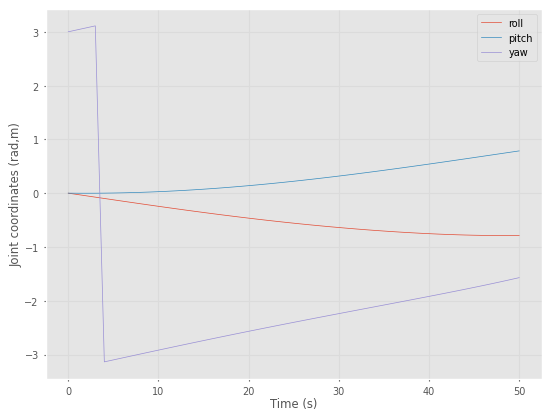

In [225]:
rpy = Ts.rpy()
xplot(rpy, labels="roll pitch yaw");

In [226]:
Ts = T0.interp(T1, trapezoidal(0, 1, 50).q);

In [227]:
Ts = ctraj(T0, T1, 50);

# 3.4 Application: Inertial Navigation


## 3.4.1 Gyroscopes


### 3.4.1.2 Estimating Orientation


In [228]:
from imu_data import IMU

true, _ = IMU()

In [229]:
orientation = UnitQuaternion();  # identity quaternion

In [230]:
for w in true.omega[:-1]:
    next = orientation[-1] @ UnitQuaternion.EulerVec(w * true.dt)
    orientation.append(next)
len(orientation)

400

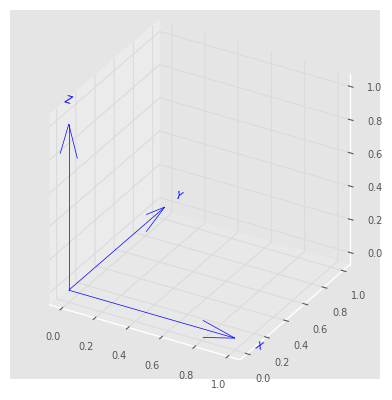

In [231]:
# orientation.animate(time=true.t)
plotvol3(new=True)
try:
    orientation.animate(time=true.t)
except Exception as e:
    print(f"Animation error: {e}")
    print("Showing orientation evolution at key time points:")
    # Show orientation at key time indices
    time_indices = [
        0,
        len(orientation) // 4,
        len(orientation) // 2,
        3 * len(orientation) // 4,
        -1,
    ]
    for i, idx in enumerate(time_indices):
        if idx < len(orientation):
            plotvol3(orientation[idx].R, alpha=0.7)
    print(
        f"Showing orientations at t={[true.t[i] for i in time_indices if i < len(true.t)]}"
    )

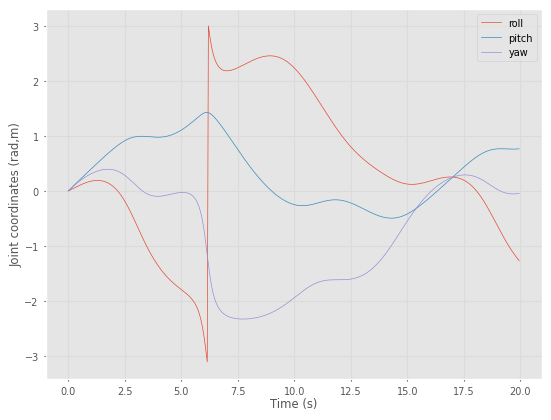

In [232]:
xplot(true.t, orientation.rpy(), labels="roll pitch yaw");

## 3.4.4 Inertial Sensor Fusion


In [233]:
from imu_data import IMU

true, imu = IMU()

In [234]:
q = UnitQuaternion()
for wm in imu.gyro[:-1]:
    q.append(q[-1] @ UnitQuaternion.EulerVec(wm * imu.dt))

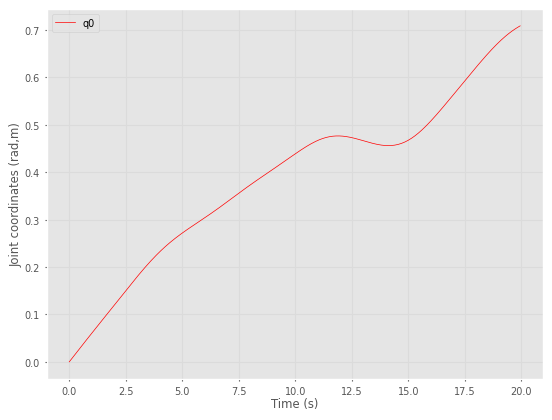

In [235]:
xplot(true.t, q.angdist(true.orientation), color="red");

In [236]:
kI = 0.2
kP = 1
b = np.zeros(imu.gyro.shape)
qcf = UnitQuaternion()
data = zip(imu.gyro[:-1], imu.accel[:-1], imu.magno[:-1])
for k, (wm, am, mm) in enumerate(data):
    qi = qcf[-1].inv()
    sR = np.cross(am, qi * true.g) + np.cross(mm, qi * true.B)
    wp = wm - b[k, :] + kP * sR
    qcf.append(qcf[k] @ UnitQuaternion.EulerVec(wp * imu.dt))
    b[k + 1, :] = b[k, :] - kI * sR * imu.dt

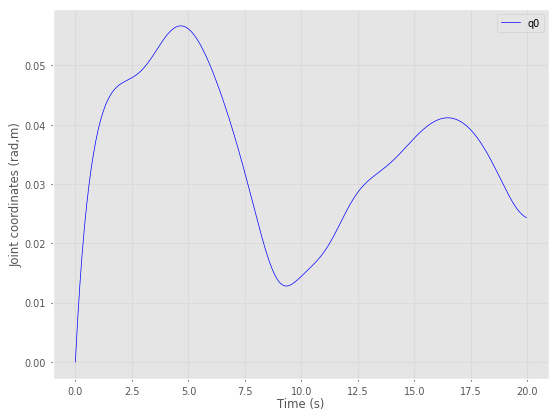

In [237]:
xplot(true.t, qcf.angdist(true.orientation), color="blue");